#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Установка библиотек
!pip install seaborn==0.11.1 -q
!pip install scikit-learn==1.5.1 -q
!pip install optuna -q
!pip install matplotlib==3.5 -q
!pip install shap -q

In [2]:
# Импорт библиотек, классов и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import optuna
import time
import gc
import os
import joblib
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor

In [3]:
# Константы и настройка
RANDOM_STATE = 42
TEST_SIZE = 0.1
N_SPLITS = 5
SCORING = "neg_root_mean_squared_error"
DIRECTION = "minimize"
SAMPLER = optuna.samplers.TPESampler(seed=RANDOM_STATE)

sns.set_theme(context="notebook", style="whitegrid", palette="deep")

Загрузим данные.

In [4]:
try:
    pth = "/datasets/taxi.csv"
    if os.path.exists(pth):
        data = pd.read_csv(pth, index_col="datetime", parse_dates=["datetime"])
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", 
        index_col="datetime", parse_dates=["datetime"])

Оценим полученные данные.

In [5]:
data.info()
data.sort_index(inplace=True)
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Произведена загрузка даных, датасет содержит 26'496 записей и состоит из двух признаков:
- **datetime** - Дата и время начала промежутка с которого производится отсчет количества заказов, судя по данным промежуток составляет 10 минут.
- **num_orders** - Количество заказов за промежуток времени.

Проверим хронологическую последовательность данных:

In [6]:
print("Монотонная последовательность:", data.index.is_monotonic)

Монотонная последовательность: True


Данные в выборке представлены промежутками по 10 минут, разрывы отсутствуют. В виду того, что целевой прогноз необходим на 1 час, произведем ресемплинг датафрейма по 1 часу:

In [7]:
data = data.resample("1H").sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Промежуточные выводы

Произведена выгрузка данных, представленный датасет содержит временной ряд, состоящий из отрезков по 10 минут и содержит 26'496 записей. Данные отсортированы по возрастанию данных и проведена оценка хронологической последовательности (монотонности) данных - данные монотонны, разрывы отсутствуют.

В соответствии с задачей произведено ресемплирование данных по одному часу. В результате ресемплинга датафрейм сократился до 4416 записей.

## Анализ

### Анализ временного ряда

In [8]:
# Фукнция добавления заголовков и подписей на график
def add_plot_titles(
    suptitle=None, suptitle_size=16, suptitle_color="C0",
    xlabel=None, xlabel_size=None, xlabel_color="k",
    ylabel=None, ylabel_size=None, ylabel_color="k",
    minor_grid=True, show=True
):
    if suptitle: plt.suptitle(suptitle, size=suptitle_size, color=suptitle_color)
    if xlabel: plt.xlabel(xlabel, size=xlabel_size, color=xlabel_color)
    if ylabel: plt.ylabel(ylabel, size=ylabel_size, color=ylabel_color)
    if minor_grid:
        plt.grid(True, which='minor', axis='x', linestyle='--', alpha=0.7)
    if show: 
        plt.tight_layout()
        plt.show()

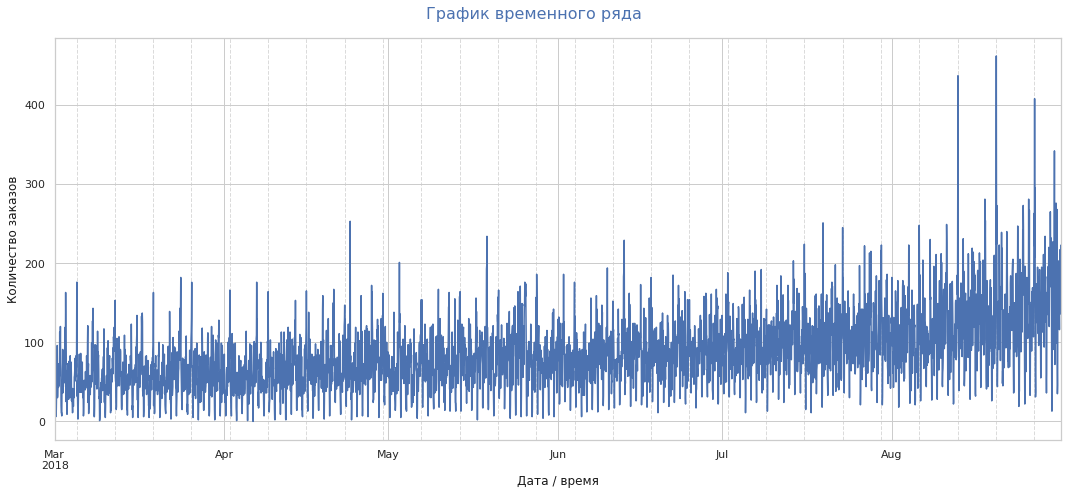

In [9]:
plt.figure(figsize=(15,7))
ax = data["num_orders"].plot()
add_plot_titles(
    suptitle="График временного ряда", xlabel="Дата / время", 
    ylabel="Количество заказов", show=True)

По графику временного ряда можно отметить, что ряд вероятнее всего нестационарный - наблюдается рост как среднего значения, так и стандартного отклонения. До июня количество заказов колеблется в основном в пределах 50-100 чаще всего не превышая 200, явные изменения не прослеживаются. С июля заметен средний рост заказов и достаточно сильно увеличивается разброс значений, особенно в большую сторону. Является ли это трендом или это сезонные изменения оценить невозможно, так как данные только за пол года. 

Взглянем на тренд временного ряда в нашем масштабе данных, по сути он из себя представляет скользящее среднее с 24-часовым окном.

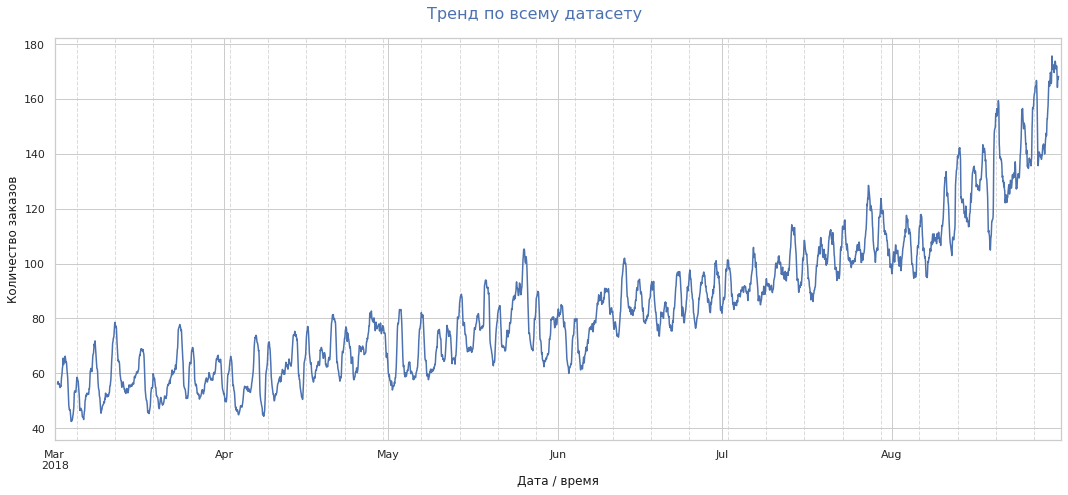

In [10]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(figsize=(15,7))
add_plot_titles(
    suptitle="Тренд по всему датасету", xlabel="Дата / время", 
    ylabel="Количество заказов", show=True)

По тренду лучше заметен рост заказов, а также некоторое снижение к началу каждого месяца, кроме июля. Средние значения возрастают от 40-80 в марте до более чем 160 к концу августа. 

Также можно отметить, что на начало практически каждой недели приходится пик восходящего тренда, после чего тренд разворачивается. Также в течение недели часто встречаются два пика - первый чуть меньше, а второй часто наибольший среди окружающих. 

Оценим сезоннность в нашем масштабе.

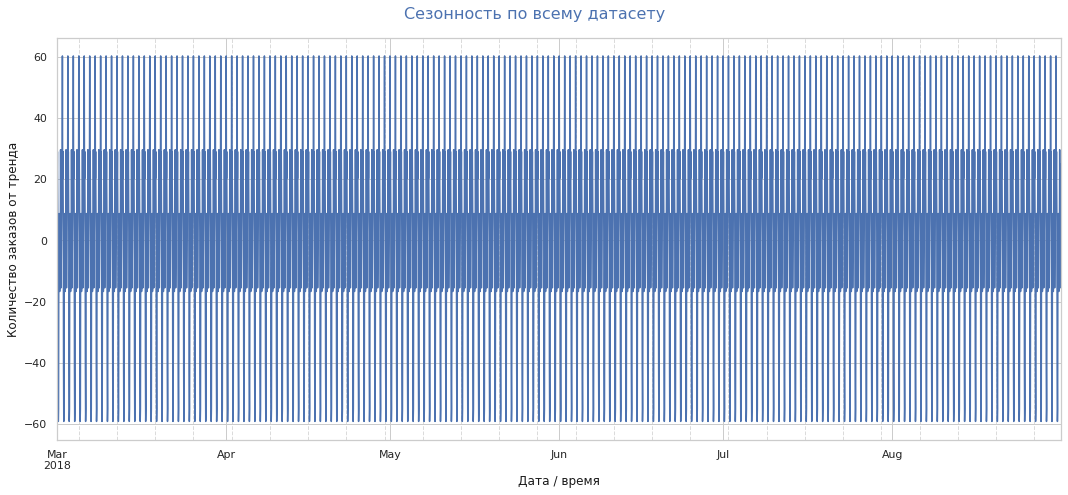

In [11]:
plt.figure(figsize=(15,7))
decomposed.seasonal.plot()
add_plot_titles(
    suptitle="Сезонность по всему датасету", xlabel="Дата / время", 
    ylabel="Количество заказов от тренда", show=True)

Если рассматривать по всему датасету график сезонности имеет довольно большую частоту, оценим график в масштабе нескольких суток.

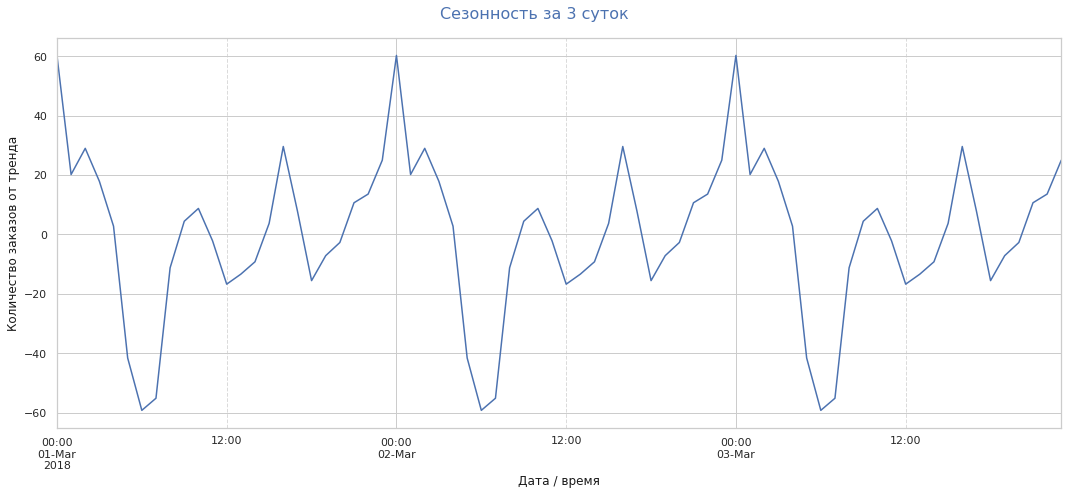

In [12]:
plt.figure(figsize=(15,7))
decomposed.seasonal["2018-03-01":"2018-03-03"].plot()
add_plot_titles(
    suptitle="Сезонность за 3 суток", xlabel="Дата / время", 
    ylabel="Количество заказов от тренда", show=True)

По сезонности можно отметить, что пик заказов приходится на полночь, а самый минимум примерно на 6 утра. Также имеется два отдельных пика значений - чуть ниже до обеда и чуть выше после него примерно на 15 часах. Оценим остаток декомпозиции.

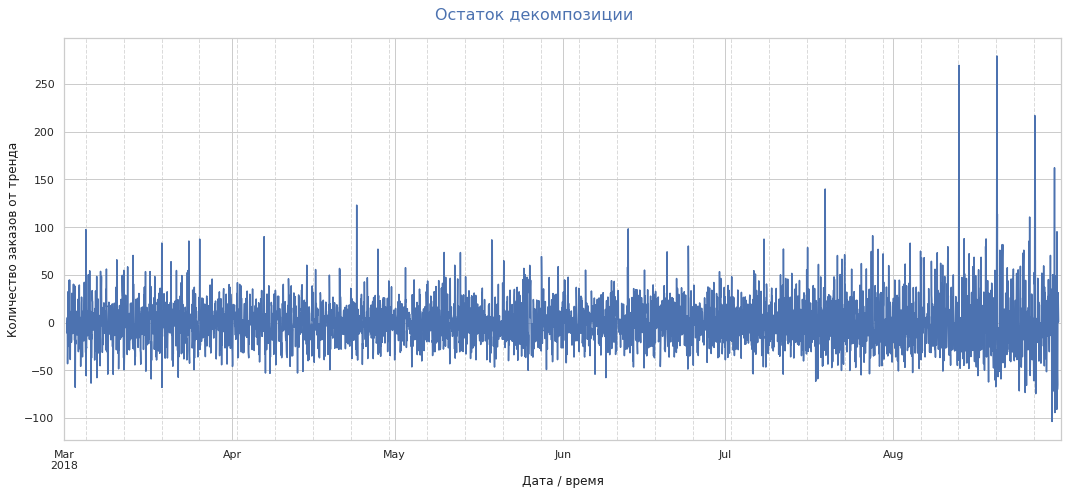

In [13]:
plt.figure(figsize=(15,7))
decomposed.resid.plot()
add_plot_titles(
    suptitle="Остаток декомпозиции", xlabel="Дата / время", 
    ylabel="Количество заказов от тренда", show=True)

По остатку заметен довольно большой разброс значений относительно тренда и сезонности, особенно в августе. Оценим также скользящее среднее по недельному окну.

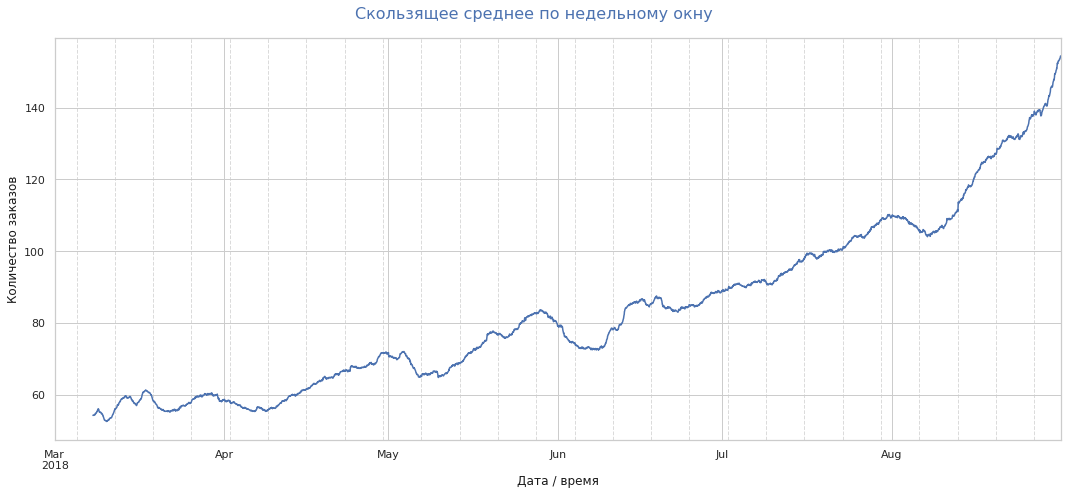

In [14]:
plt.figure(figsize=(15,7))
data["num_orders"].rolling(24*7, closed="left").mean().plot()
add_plot_titles(
    suptitle="Скользящее среднее по недельному окну", xlabel="Дата / время", 
    ylabel="Количество заказов", show=True)

По недельному окну график более сглаженный, также на этом графике заметнее снижение количество заказов в начале месяца, а также рост заказов с июля и особенно в августе. Наблюдается явный тренд на повышение с начала апреля, что также говорит в пользу нестационарности временного ряда.

Для оценки стационарности воспользуемся тестом Дики-Фуллера (ADF - Augmented Dickey-Fuller) со следующей постановкой гипотез:
- **Нулевая гипотеза H0**: Временной ряд имеет единичный корень и, следовательно, является нестационарным.
- **Альтернативная гипотеза H1**: Временной ряд стационарен.

Проверку гипотезы о стационарности временного ряда проведем для двух уровней значимости — 5% и 1%.

In [15]:
alpha = {"5%": 0.05, "1%": 0.01}
adf = adfuller(data["num_orders"])
print(f"Значение p-value: {adf[1]}")
for txt, pval in alpha.items():
    if pval > adf[1]:
        print(f"Отклоняем нулевую гипотезу на уровне значимости {txt}: временной ряд вероятно стационарен.")
    else:
        print(f"Не можем отклонить нулевую гипотезу на уровне значимости {txt}: временной ряд вероятно не стационарен.")

Значение p-value: 0.028940051402612906
Отклоняем нулевую гипотезу на уровне значимости 5%: временной ряд вероятно стационарен.
Не можем отклонить нулевую гипотезу на уровне значимости 1%: временной ряд вероятно не стационарен.


Результаты теста ADF между 1% и 5%, это говорит о том, что временной ряд находится на грани стационарности. При более строгом уровне значимости (1%) ряд можно считать нестационарным, но при менее строгом уровне (5%) — можно считать стационарным. Если важно достичь высокой уверенности в результатах теста, лучше ориентироваться на уровень значимости 1% и считать временной ряд нестационарным.

### Добавление признаков

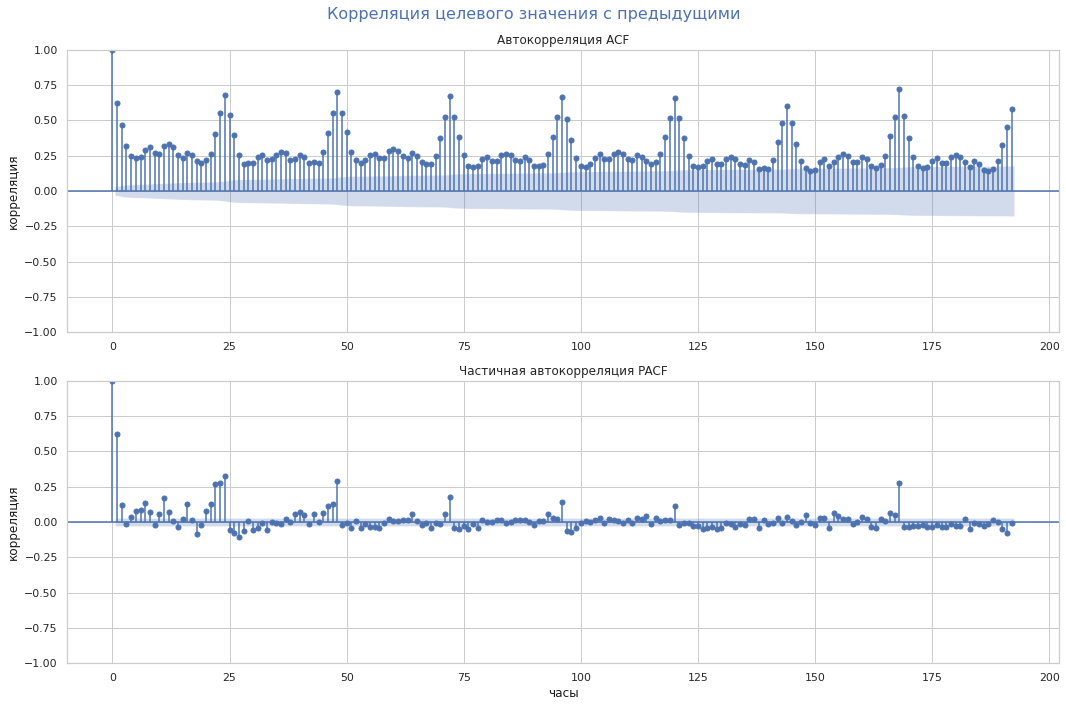

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(data["num_orders"], ax=plt.gca(), lags=192, title="Автокорреляция ACF")
add_plot_titles(ylabel="корреляция", show=False)
plt.subplot(212)
plot_pacf(data["num_orders"], ax=plt.gca(), lags=192, title="Частичная автокорреляция PACF", method="ywm")
add_plot_titles(suptitle="Корреляция целевого значения с предыдущими", 
                xlabel="часы", ylabel="корреляция", show=True)

По функциям вывода автокорреляции можно отметить высокую корреляцию по суточным отклонениям от целевого признака, а также очень высокая корреляция с недельным отклонением. По функции PACF можно определить наиболее влиятельные лаги от целевого, к которым можно отнести первые 2 лага, а также лаги в 22-24 часа, 48 часов и 168 часов (7 дней). Остальные ежесуточные лаги идут по ниспадающей значения корреляции.

In [17]:
# Функция для добавления признаков
def make_features(
    data: pd.Series, dates=False, lags: int=0, 
    rollings=0, rol_func="mean"
) -> pd.DataFrame:
    result = data.copy().to_frame()
    if dates:
        result["day"] = data.index.day
        result["dayofweek"] = data.index.dayofweek
        result["hour"] = data.index.hour
    if isinstance(lags, int) and (lags > 0):
        for lag in range(1, lags+1):
            result[f"lag_{lag}"] = data.shift(lag)
    elif isinstance(lags, list):
        for lag in lags:
            result[f"lag_{lag}"] = data.shift(lag)
    if isinstance(rollings, int) and (rollings > 1):
        for rolling in range(2, rollings+1):
            result[f"rol_{rol_func}_{rolling}"] = data.shift().rolling(rolling).agg(rol_func)
    elif isinstance(rollings, list):
        for rolling in rollings:
            result[f"rol_{rol_func}_{rolling}"] = data.shift().rolling(rolling).agg(rol_func)
    return result

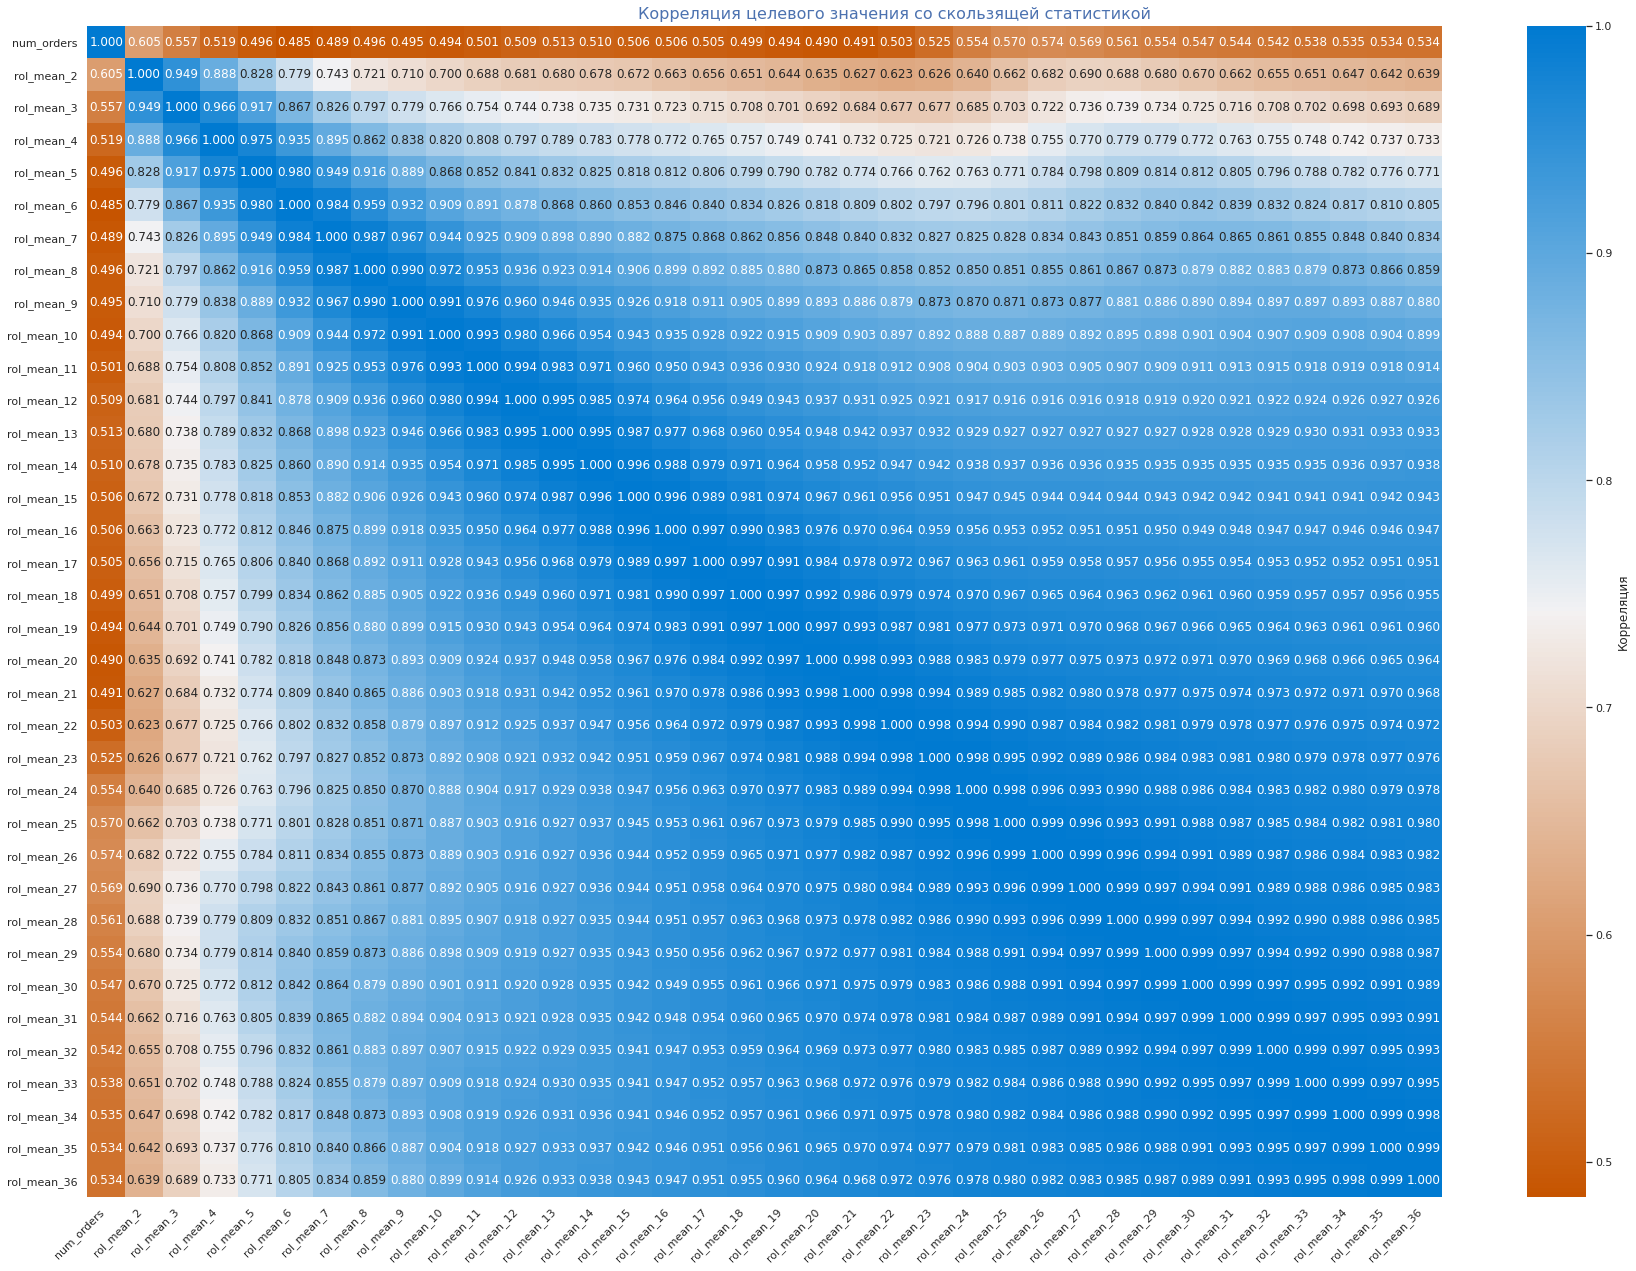

In [18]:
plt.figure(figsize=(25, 18))
sns.heatmap(
    make_features(data["num_orders"], rollings=36).corr(),
    annot=True, fmt=".3f", cbar_kws={"label": "Корреляция"},
    cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
)
plt.xticks(rotation=45, ha="right")
add_plot_titles(suptitle="Корреляция целевого значения со скользящей статистикой", show=True)

По корреляции целевого признака со скользящей средней (проверил также скользящие медиану и стандартное отклонение, наилучшая корреляция у средней) можно отметить, что лучшие значения с целевой дают 2-часовая, 13 часовая и 26-часовая скользящая средняя, остальные показывают более низкие результаты. Так как 

Можно подготовить наиболее подходящие признаки - производные от времени, такие как час, день, день недели (в нашем случае год не меняется, а по месяцу имеются не все данные - что может затруднить работу некоторых моделей при получении нового значения месяца), лаг за предыдущие 2 часа, 22-24 часа, 48 часов и 168 часов, а также скользящую среднуюю на 2, 13 и 26 часов. Единственная проблема - первые 7 дней для обучения не получится задействовать. Оценим корреляцию выбранных признаков.

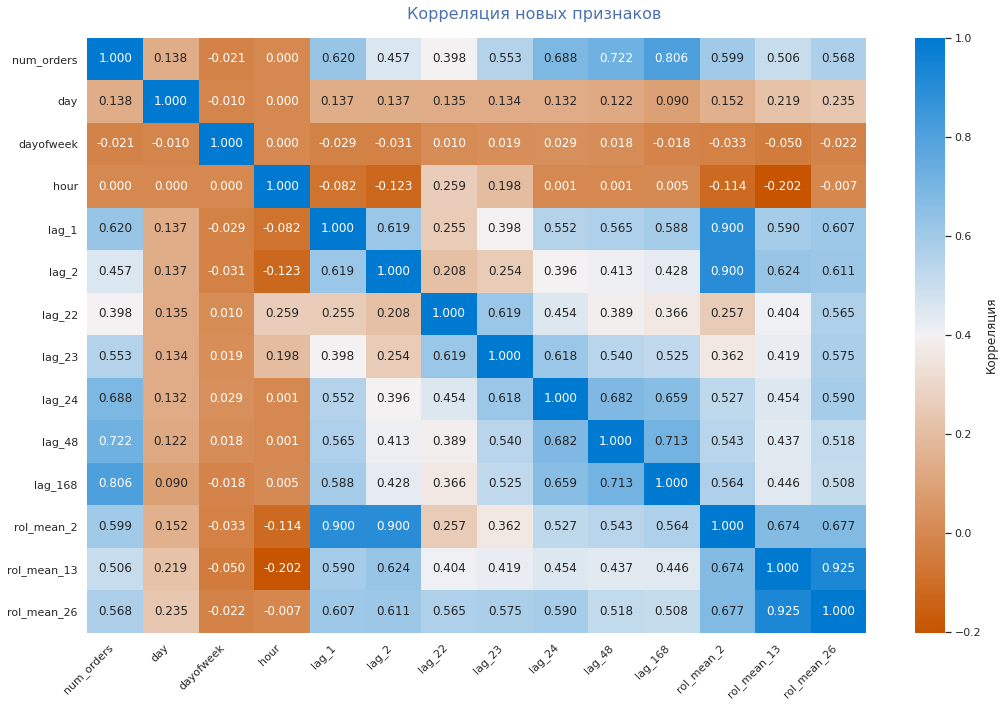

In [19]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    make_features(data["num_orders"], dates=True, 
                  lags=[1, 2, 22, 23, 24, 48, 168], 
                  rollings=[2, 13, 26]).dropna().corr(),
    annot=True, fmt=".3f", cbar_kws={"label": "Корреляция"},
    cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
)
plt.xticks(rotation=45, ha="right")
add_plot_titles(suptitle="Корреляция новых признаков", show=True)

Наиболее высокая корреляция целевого признака с недельным (168-часовым) и 48-часовым лагом - 0.806 и 0.722 соответственно. Заметная корреляция с 24-часовым, 1-часовым и 23-часовым лагом - 0.688, 0.620 и 0.553 соответственно, также со скользящими средними с окном на 2, 26 и 13 часов - 0.599, 0.568 и 0.506 соответственно. Умеренная корреляция с остальными лагами - 2-часовым и 22-часовым. С признаками часа, дня и дня недели корреляция очень низкая.

Мультиколлинеарность наблюдается у скользящих средних, корреляция 2-часовой скользящей средней с лагами в 1 и 2 часа составляет 0.9, а у 13-часовой и 26-часовой корреляция между ними составляет 0.925. Соответственно лучше не использовать 2-часовую (учитывая, что имеется лаг за предыдущие 2 часа) и 13-часовую скользящие средние для снижения влияния мультиколлинеарности на модели. Так как удаляем 13-часовую скользящую среднюю, решил добавить 3-часовой, 7-часовой, 11-часовой и 16-часовой лаг, который показывает наибольшую частичную корреляцию среди оставшихся предыдущих значений до 24 часов. Добавим новые признаки в датасет.

In [20]:
print("Размер датасета до добавления признаков:", data.shape)
data = make_features(
    data["num_orders"], dates=True, 
    lags=[1, 2, 7, 11, 16, 22, 23, 24, 48, 168], 
    rollings=[26]
).dropna()
print("Размер датасета после добавления признаков:", data.shape)

Размер датасета до добавления признаков: (4416, 1)
Размер датасета после добавления признаков: (4248, 15)


После добавления признаков из датасета исключены 7 дней (168 часов).

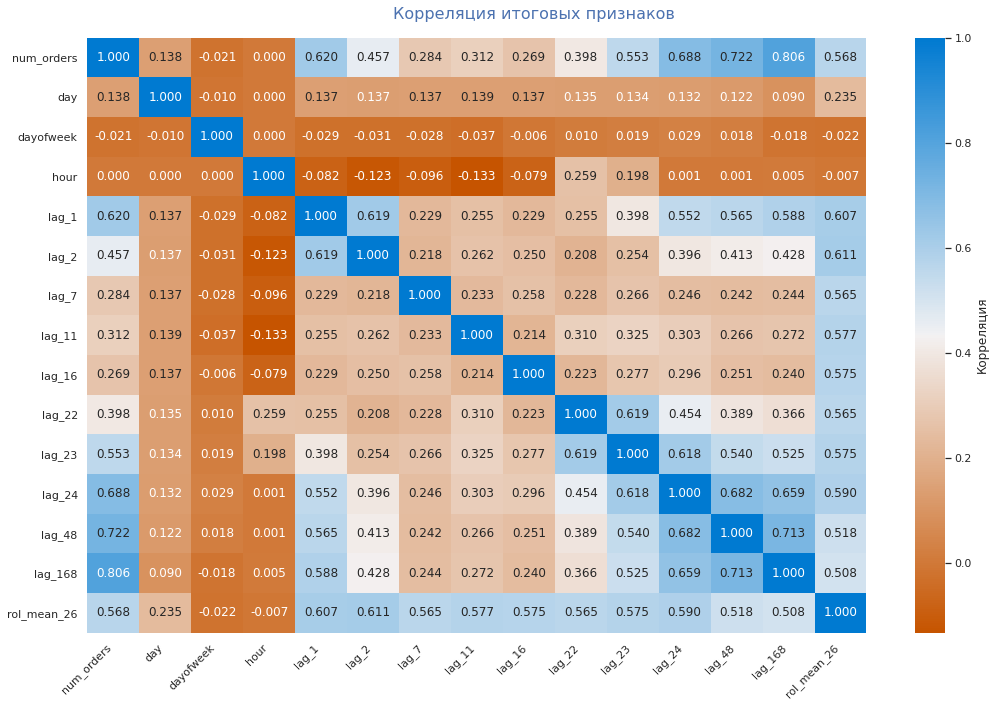

In [21]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    data.corr(),
    annot=True, fmt=".3f", cbar_kws={"label": "Корреляция"},
    cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
)
plt.xticks(rotation=45, ha="right")
add_plot_titles(suptitle="Корреляция итоговых признаков", show=True)

В результате последних преобразований удалось избавиться от сильной корреляция между признаками. Приступим к обучению моделей.

### Промежуточные выводы

Произведен анализ временного ряда и проведена инженерия признаков, в результате которой добавлены новые признаки:
1. Признаки даты и времени - день месяца, день недели, час;
2. Лаговые признаки - предыдущие значения количества заказов за 1, 2, 7, 11, 16, 22-24, а также 48 и 168 часов до текущего;
3. Скользящая средняя с окном в 26 часов.

Размер датасета увеличился на 15 признаков, при этом количество строк сократилось на 168 (первая неделя).

## Обучение

### Подготовка

Разделим датасет на тренировочную и тестовую выборки.

In [22]:
train, test = train_test_split(
    data, shuffle=False,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
print("Размер тренировочной выборки:", train.shape)
print(f"Период тренировочной выборки с {train.index.min()} по {train.index.max()}")
print("Размер тестовой выборки:", test.shape)
print(f"Период тестовой выборки с {test.index.min()} по {test.index.max()}")

Размер тренировочной выборки: (3823, 15)
Период тренировочной выборки с 2018-03-08 00:00:00 по 2018-08-14 06:00:00
Размер тестовой выборки: (425, 15)
Период тестовой выборки с 2018-08-14 07:00:00 по 2018-08-31 23:00:00


В нашем случае стоит задача регрессии на базе временных рядов - предсказание количества заказов такси на следующий час. Для подбора наилучшей модели машинного обучения произведем оценку следующих моделей:
1. Линейная модель;
2. Модель SVM;
3. Модель kNN;
4. Модель Decision Tree;
5. Модель Random Forest;
6. Модель XGBoost;
7. Модель LightGBM;
8. Модель CatBoost.

Для каждой модели будет произведен поиск гиперпараметров посредством библиотеки Optuna, а также кросс-валидация на тренировочной выборке для оценки метрик. Для проведения кросс-валидации временных рядов будет использоваться TimeSeriesSplit.

In [23]:
#Выбор кросс-валидатора
cv = TimeSeriesSplit(n_splits=N_SPLITS)

In [24]:
#Переменная для сохранения результатов
model_results = pd.DataFrame()
model_params = pd.Series(dtype="float64")

#Функция для измерения времени обучения и предсказания
def fit_predict_results(model, 
                        X=train.drop(columns=["num_orders"]), y=train["num_orders"]):
    # Обучение модели
    pb = tqdm(total=2, desc="Обучение модели")
    learn_time = time.time()
    model.fit(X, y)
    learn_time = time.time() - learn_time
    pb.update(1)
    print(f"Время обучения модели: {learn_time:.3f} секунд")
    # Предсказание модели
    pb.set_description("Предсказание модели")
    predict_time = time.time()
    y_pred = model.predict(X)
    predict_time = time.time() - predict_time
    print(f"Время предсказания модели: {predict_time:.3f} секунд")
    pb.update(1)
    pb.set_description("Процесс завершен")
    pb.close()
    #result_metric = metric(y, y_pred)
    #print(f"Метрика модели: {result_metric:.4f}")
    
    # Возвращение результата
    return {
        "learn_time": learn_time,
        "predict_time": predict_time
    }

In [25]:
def save_results(model_name, study=None, display_study=True, train_results=None):
    print(f"Модель {model_name}")
    if study:
        model_results.loc[model_name, "cross_val_rmse"] = study.best_value
        model_params[model_name] = study.best_params
        if display_study:
            print("Лучшие гиперпараметры:", study.best_params)
            print("Лучшее значение RMSE:", study.best_value)
    if train_results:
        model_results.loc[model_name, "learn_time"] = train_results["learn_time"]
        model_results.loc[model_name, "predict_time"] = train_results["predict_time"]
        #model_results.loc[model_name, "train_rmse"] = train_results["metric"]

### Линейная модель

В качестве модели линейной регрессии будем использовать Ridge с L2-регуляризацией.

In [26]:
model_name = "Ridge"

#Функция оптимизации гиперпараметров модели
def lr_optimize(trial):
    alpha = trial.suggest_float("alpha", 0.01, 1000000.0, log=True)
    model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]),
        train["num_orders"], cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [27]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction=DIRECTION, study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
study.optimize(lr_optimize, n_trials=32, show_progress_bar=True)

[I 2024-09-08 08:15:34,436] A new study created in memory with name: Ridge


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2024-09-08 08:15:34,533] Trial 0 finished with value: 22.495022432413315 and parameters: {'alpha': 9.915644566638388}. Best is trial 0 with value: 22.495022432413315.
[I 2024-09-08 08:15:34,735] Trial 1 finished with value: 22.895924717347356 and parameters: {'alpha': 403380.08326003805}. Best is trial 0 with value: 22.495022432413315.
[I 2024-09-08 08:15:34,928] Trial 2 finished with value: 22.49759640158058 and parameters: {'alpha': 7177.141927992012}. Best is trial 0 with value: 22.495022432413315.
[I 2024-09-08 08:15:35,125] Trial 3 finished with value: 22.495050022005284 and parameters: {'alpha': 615.5564318973003}. Best is trial 0 with value: 22.495022432413315.
[I 2024-09-08 08:15:35,323] Trial 4 finished with value: 22.495022466522016 and parameters: {'alpha': 0.17707168643537816}. Best is trial 0 with value: 22.495022432413315.
[I 2024-09-08 08:15:35,444] Trial 5 finished with value: 22.495022466522357 and parameters: {'alpha': 0.17699302940633327}. Best is trial 0 with val

In [28]:
# Результаты кросс-валидации
save_results("Ridge", study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель Ridge
Лучшие гиперпараметры: {'alpha': 25.85715034294035}
Лучшее значение RMSE: 22.49502241044309


Оценим время обучения и предсказания модели на тестовой выборке.

In [29]:
model = Ridge(
    alpha = model_params[model_name]["alpha"],
    random_state = RANDOM_STATE
)

# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results(model_name, train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 0.011 секунд
Время предсказания модели: 0.003 секунд
Модель Ridge


### Модель SVM

In [30]:
model_name = "SVM"

#Функция оптимизации гиперпараметров модели
def svm_optimize(trial):
    C = trial.suggest_float("C", 1.0, 40.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["poly", "rbf", "sigmoid"])
    model = SVR(C=C, kernel=kernel)
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]),
        train["num_orders"], cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [31]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction="minimize", study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
study.optimize(svm_optimize, n_trials=32, show_progress_bar=True)

[I 2024-09-08 08:15:42,376] A new study created in memory with name: SVM


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2024-09-08 08:15:43,756] Trial 0 finished with value: 29.340520326335866 and parameters: {'C': 1.0788910608175064, 'kernel': 'poly'}. Best is trial 0 with value: 29.340520326335866.
[I 2024-09-08 08:15:45,813] Trial 1 finished with value: 72.48001481511886 and parameters: {'C': 1.955665189160277, 'kernel': 'sigmoid'}. Best is trial 0 with value: 29.340520326335866.
[I 2024-09-08 08:15:47,269] Trial 2 finished with value: 25.328065712697175 and parameters: {'C': 4.920416122028322, 'kernel': 'rbf'}. Best is trial 2 with value: 25.328065712697175.
[I 2024-09-08 08:15:49,263] Trial 3 finished with value: 90.35570212716863 and parameters: {'C': 2.9378745907950186, 'kernel': 'sigmoid'}. Best is trial 2 with value: 25.328065712697175.
[I 2024-09-08 08:15:50,670] Trial 4 finished with value: 26.672255698789094 and parameters: {'C': 2.0887640189051555, 'kernel': 'rbf'}. Best is trial 2 with value: 25.328065712697175.
[I 2024-09-08 08:15:52,680] Trial 5 finished with value: 213.27729197115008

In [32]:
# Результаты кросс-валидации
save_results(model_name, study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель SVM
Лучшие гиперпараметры: {'C': 29.213316517677093, 'kernel': 'rbf'}
Лучшее значение RMSE: 24.17079486372838


Оценим время обучения и предсказания модели на тестовой выборке.

In [33]:
model = SVR(
    C = model_params[model_name]["C"],
    kernel = model_params[model_name]["kernel"]
)

# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results(model_name, train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 0.842 секунд
Время предсказания модели: 0.698 секунд
Модель SVM


### Модель kNN

In [34]:
model_name = "kNN"

#Функция оптимизации гиперпараметров модели
def knn_optimize(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 40)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_categorical("p", [1, 2])
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors, 
        weights=weights, p=p,
        n_jobs=-1
    )
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]),
        train["num_orders"], cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [35]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction="minimize", study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
study.optimize(knn_optimize, n_trials=32, show_progress_bar=True)

[I 2024-09-08 08:17:05,886] A new study created in memory with name: kNN


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2024-09-08 08:17:06,158] Trial 0 finished with value: 23.87153299482221 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 23.87153299482221.
[I 2024-09-08 08:17:06,370] Trial 1 finished with value: 24.081350523565675 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 23.87153299482221.
[I 2024-09-08 08:17:06,603] Trial 2 finished with value: 23.72187978030636 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 23.72187978030636.
[I 2024-09-08 08:17:06,798] Trial 3 finished with value: 23.983839217994188 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 23.72187978030636.
[I 2024-09-08 08:17:07,036] Trial 4 finished with value: 23.908538947759627 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 23.72187978030636.
[I 2024-09-08 08:17:07,309] Trial 5 finished wit

In [36]:
# Результаты кросс-валидации
save_results(model_name, study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель kNN
Лучшие гиперпараметры: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}
Лучшее значение RMSE: 23.71462384548422


Оценим время обучения и предсказания модели на тестовой выборке.

In [37]:
model = KNeighborsRegressor(
    n_neighbors=model_params[model_name]["n_neighbors"], 
    weights=model_params[model_name]["weights"], 
    p=model_params[model_name]["p"],
    n_jobs=-1
)

# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results(model_name, train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 0.007 секунд
Время предсказания модели: 0.380 секунд
Модель kNN


### Модель Decision Tree

In [38]:
model_name = "DecisionTree"

#Функция оптимизации гиперпараметров модели
def dt_optimize(trial):
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    model = DecisionTreeRegressor(
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE
    )
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]),
        train["num_orders"], cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [39]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction="minimize", study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
study.optimize(dt_optimize, n_trials=32, show_progress_bar=True)

[I 2024-09-08 08:17:14,078] A new study created in memory with name: DecisionTree


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2024-09-08 08:17:14,139] Trial 0 finished with value: 28.355167502652773 and parameters: {'max_depth': 2, 'min_samples_split': 33, 'min_samples_leaf': 16}. Best is trial 0 with value: 28.355167502652773.
[I 2024-09-08 08:17:14,226] Trial 1 finished with value: 25.666826328211293 and parameters: {'max_depth': 26, 'min_samples_split': 46, 'min_samples_leaf': 13}. Best is trial 1 with value: 25.666826328211293.
[I 2024-09-08 08:17:14,324] Trial 2 finished with value: 25.900230364961715 and parameters: {'max_depth': 21, 'min_samples_split': 39, 'min_samples_leaf': 12}. Best is trial 1 with value: 25.666826328211293.
[I 2024-09-08 08:17:14,384] Trial 3 finished with value: 25.859100150180474 and parameters: {'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 1 with value: 25.666826328211293.
[I 2024-09-08 08:17:14,476] Trial 4 finished with value: 25.662422900430272 and parameters: {'max_depth': 47, 'min_samples_split': 41, 'min_samples_leaf': 32}. Best is tri

In [40]:
# Результаты кросс-валидации
save_results(model_name, study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель DecisionTree
Лучшие гиперпараметры: {'max_depth': 6, 'min_samples_split': 29, 'min_samples_leaf': 23}
Лучшее значение RMSE: 25.24410983729812


Оценим время обучения и предсказания модели на тестовой выборке.

In [41]:
model = DecisionTreeRegressor(
    max_depth=model_params[model_name]["max_depth"], 
    min_samples_split=model_params[model_name]["min_samples_split"],
    min_samples_leaf=model_params[model_name]["min_samples_leaf"],
    random_state=RANDOM_STATE
)

# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results(model_name, train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 0.020 секунд
Время предсказания модели: 0.003 секунд
Модель DecisionTree


### Модель Random Forest

In [42]:
model_name = "RandomForest"

#Функция оптимизации гиперпараметров модели
def rf_optimize(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features=trial.suggest_categorical("max_features", ["sqrt", "log2"])
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=RANDOM_STATE, n_jobs=-1
    )
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]),
        train["num_orders"], cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [43]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction="minimize", study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
# Сократил количество итераций для ускорения процесса поиска гиперпараметров
study.optimize(rf_optimize, n_trials=16, show_progress_bar=True)

[I 2024-09-08 08:17:17,653] A new study created in memory with name: RandomForest


  0%|          | 0/16 [00:00<?, ?it/s]

[I 2024-09-08 08:17:23,952] Trial 0 finished with value: 23.390362984362813 and parameters: {'n_estimators': 500, 'learning_rate': 0.03, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 23.390362984362813.
[I 2024-09-08 08:17:38,988] Trial 1 finished with value: 22.68997795704316 and parameters: {'n_estimators': 800, 'learning_rate': 0.04, 'max_depth': 49, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 22.68997795704316.
[I 2024-09-08 08:17:45,677] Trial 2 finished with value: 22.600021134601075 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 22.600021134601075.
[I 2024-09-08 08:17:51,429] Trial 3 finished with value: 22.724544435920176 and parameters: {'n_estimators': 300, 'learning_rate': 0.02, 'max_depth': 25, 'min_samples_split': 15, '

In [44]:
# Результаты кросс-валидации
save_results(model_name, study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель RandomForest
Лучшие гиперпараметры: {'n_estimators': 900, 'learning_rate': 0.060000000000000005, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}
Лучшее значение RMSE: 22.592507991688297


Оценим время обучения и предсказания модели на тестовой выборке.

In [45]:
model = RandomForestRegressor(
    n_estimators=model_params[model_name]["n_estimators"],
    max_depth=model_params[model_name]["max_depth"], 
    min_samples_split=model_params[model_name]["min_samples_split"],
    min_samples_leaf=model_params[model_name]["min_samples_leaf"],
    max_features=model_params[model_name]["max_features"],
    random_state=RANDOM_STATE, n_jobs=-1
)

# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results(model_name, train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 7.626 секунд
Время предсказания модели: 0.565 секунд
Модель RandomForest


### Модель XGBoost

In [46]:
model_name = "XGBoost"

#Функция оптимизации гиперпараметров модели
def xgb_optimize(trial):
    #n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    n_estimators = trial.suggest_int("n_estimators", 500, 1000, step=100)
    #max_depth = trial.suggest_int("max_depth", 1, 50)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    #subsample = trial.suggest_float("subsample", 0.1, 0.9, step=0.1)
    subsample = trial.suggest_float("subsample", 0.5, 0.9, step=0.1)
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth, 
        subsample=subsample,
        random_state=RANDOM_STATE, n_jobs=-1
    )
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]), train["num_orders"], 
        n_jobs=-1, cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [47]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction="minimize", study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
# Изменил области поиска гиперпараметров и сократил количество итераций
study.optimize(xgb_optimize, n_trials=4, show_progress_bar=True) 

[I 2024-09-08 08:20:38,623] A new study created in memory with name: XGBoost


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2024-09-08 08:22:55,685] Trial 0 finished with value: 24.68129160930348 and parameters: {'n_estimators': 800, 'max_depth': 1, 'subsample': 0.5}. Best is trial 0 with value: 24.68129160930348.
[I 2024-09-08 08:27:02,121] Trial 1 finished with value: 26.5933641048531 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'subsample': 0.5}. Best is trial 0 with value: 24.68129160930348.
[I 2024-09-08 08:28:31,627] Trial 2 finished with value: 26.571071278549663 and parameters: {'n_estimators': 500, 'max_depth': 4, 'subsample': 0.5}. Best is trial 0 with value: 24.68129160930348.
[I 2024-09-08 08:30:09,648] Trial 3 finished with value: 26.261424735875785 and parameters: {'n_estimators': 500, 'max_depth': 3, 'subsample': 0.8}. Best is trial 0 with value: 24.68129160930348.


In [48]:
# Результаты кросс-валидации
save_results(model_name, study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель XGBoost
Лучшие гиперпараметры: {'n_estimators': 800, 'max_depth': 1, 'subsample': 0.5}
Лучшее значение RMSE: 24.68129160930348


Оценим время обучения и предсказания модели на тестовой выборке.

In [49]:
model = xgb.XGBRegressor(
    n_estimators=model_params[model_name]["n_estimators"],
    max_depth=model_params[model_name]["max_depth"], 
    subsample=model_params[model_name]["subsample"],
    random_state=RANDOM_STATE, n_jobs=-1
)

# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results(model_name, train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 29.943 секунд
Время предсказания модели: 0.043 секунд
Модель XGBoost


### Модель LightGBM

In [50]:
model_name = "LightGBM"

#Функция оптимизации гиперпараметров модели
def lgb_optimize(trial):
    #n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    n_estimators = trial.suggest_int("n_estimators", 200, 500, step=100)
    #num_leaves = trial.suggest_categorical("num_leaves", [31, 63, 127])
    num_leaves = trial.suggest_categorical("num_leaves", [31, 63])
    #learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.05, step=0.01)
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators, 
        num_leaves=num_leaves, 
        learning_rate=learning_rate, 
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1
    )
    #model.set_params(**{"categorical_feature":list(range(4))})
    # Не понимаю почему при установке categorical_feature выдает UserWarning,
    # результаты чуть лучше с установкой, но с другими гиперпараметрами
    # закомментировал строку, чтобы не было warning'а
    
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]), train["num_orders"], 
        n_jobs=-1, cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [51]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction="minimize", study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
# Изменил области поиска гиперпараметров и сократил количество итераций
study.optimize(lgb_optimize, n_trials=8, show_progress_bar=True) 

[I 2024-09-08 08:30:40,056] A new study created in memory with name: LightGBM


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-09-08 08:31:17,733] Trial 0 finished with value: 23.192874284470207 and parameters: {'n_estimators': 400, 'num_leaves': 63, 'learning_rate': 0.02}. Best is trial 0 with value: 23.192874284470207.
[I 2024-09-08 08:31:32,834] Trial 1 finished with value: 23.329703672359635 and parameters: {'n_estimators': 300, 'num_leaves': 31, 'learning_rate': 0.05}. Best is trial 0 with value: 23.192874284470207.
[I 2024-09-08 08:32:02,629] Trial 2 finished with value: 23.086509116566738 and parameters: {'n_estimators': 400, 'num_leaves': 31, 'learning_rate': 0.02}. Best is trial 2 with value: 23.086509116566738.
[I 2024-09-08 08:32:34,132] Trial 3 finished with value: 23.119544265910115 and parameters: {'n_estimators': 300, 'num_leaves': 63, 'learning_rate': 0.02}. Best is trial 2 with value: 23.086509116566738.
[I 2024-09-08 08:33:19,028] Trial 4 finished with value: 23.40085465660806 and parameters: {'n_estimators': 500, 'num_leaves': 63, 'learning_rate': 0.03}. Best is trial 2 with value: 2

In [52]:
# Результаты кросс-валидации
save_results(model_name, study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель LightGBM
Лучшие гиперпараметры: {'n_estimators': 400, 'num_leaves': 31, 'learning_rate': 0.02}
Лучшее значение RMSE: 23.086509116566738


Оценим время обучения и предсказания модели на тестовой выборке.

In [53]:
model = lgb.LGBMRegressor(
    n_estimators=model_params[model_name]["n_estimators"], 
    num_leaves=model_params[model_name]["num_leaves"], 
    learning_rate=model_params[model_name]["learning_rate"], 
    random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1
)
#model.set_params(**{"categorical_feature":list(range(4))})

# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results("LightGBM", train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 8.434 секунд
Время предсказания модели: 0.103 секунд
Модель LightGBM


### Модель CatBoost

In [54]:
model_name = "CatBoost"

#Функция оптимизации гиперпараметров модели
def cb_optimize(trial):
    #iterations = trial.suggest_int("iterations", 100, 1000, step=100)
    iterations = trial.suggest_int("iterations", 800, 900, step=100)
    #depth = trial.suggest_int("depth", 1, 16)
    depth = trial.suggest_int("depth", 9, 9)
    #learning_rate = trial.suggest_float("learning_rate", 0.01, 0.9, step=0.01)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.02, step=0.01)
    model = cb.CatBoostRegressor(
        cat_features=list(range(3)),
        iterations=iterations,
        depth=depth, 
        learning_rate=learning_rate, 
        thread_count=-1, verbose=0,
        random_seed=RANDOM_STATE
    )
    return -cross_val_score(
        model, train.drop(columns=["num_orders"]), train["num_orders"],
        n_jobs=-1, cv=cv, scoring=SCORING).mean()

Проведем поиск лучших гиперпараметров по результатам кросс-валидации и получим метрики модели.

In [55]:
# Определение параметров поиска Optuna
study = optuna.create_study(
    direction="minimize", study_name=model_name, sampler=SAMPLER
)

# Поиск лучших гиперпараметров с кросс-валидацией
# Изменил области поиска гиперпараметров и сократил количество итераций
study.optimize(cb_optimize, n_trials=4, show_progress_bar=True)

[I 2024-09-08 08:34:57,140] A new study created in memory with name: CatBoost


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2024-09-08 08:36:44,014] Trial 0 finished with value: 22.498600979038493 and parameters: {'iterations': 800, 'depth': 9, 'learning_rate': 0.02}. Best is trial 0 with value: 22.498600979038493.
[I 2024-09-08 08:38:30,956] Trial 1 finished with value: 22.498600979038493 and parameters: {'iterations': 800, 'depth': 9, 'learning_rate': 0.02}. Best is trial 0 with value: 22.498600979038493.
[I 2024-09-08 08:40:32,176] Trial 2 finished with value: 22.510538479047103 and parameters: {'iterations': 900, 'depth': 9, 'learning_rate': 0.02}. Best is trial 0 with value: 22.498600979038493.
[I 2024-09-08 08:42:12,315] Trial 3 finished with value: 22.570424984443086 and parameters: {'iterations': 800, 'depth': 9, 'learning_rate': 0.01}. Best is trial 0 with value: 22.498600979038493.


In [56]:
# Результаты кросс-валидации
save_results(model_name, study=study)

# Очистка переменных для снижения влияния на обучение
del study
gc.collect();

Модель CatBoost
Лучшие гиперпараметры: {'iterations': 800, 'depth': 9, 'learning_rate': 0.02}
Лучшее значение RMSE: 22.498600979038493


Оценим время обучения и предсказания модели на тестовой выборке.

In [57]:
model = cb.CatBoostRegressor(
    cat_features=list(range(3)),
    iterations=model_params[model_name]["iterations"],
    depth=model_params[model_name]["depth"], 
    learning_rate=model_params[model_name]["learning_rate"], 
    thread_count=-1, verbose=0,
    random_seed=RANDOM_STATE
)
# Получение и сохранение результатов на тестовой выборке
train_results = fit_predict_results(model)
save_results(model_name, train_results=train_results)

# Сохранение модели в файл
os.makedirs("models", exist_ok=True) # создание директории, если её ещё нет
with open(f"models/{model_name}.pkl", "wb") as fd:
    joblib.dump(model, fd) # сохранине дампа модели

# Очистка переменных для освобождения ресурсов
del model, train_results
gc.collect();

Обучение модели:   0%|          | 0/2 [00:00<?, ?it/s]

Время обучения модели: 28.124 секунд
Время предсказания модели: 0.024 секунд
Модель CatBoost


### Промежуточные выводы

In [58]:
model_results.sort_values("cross_val_rmse").style.background_gradient(
    cmap=sns.diverging_palette(250, 20, as_cmap=True)
).format("{:,.4f}")

,cross_val_rmse,learn_time,predict_time
Ridge,22.4950,0.0110,0.0031
CatBoost,22.4986,28.1235,0.0245
RandomForest,22.5925,7.6260,0.5654
LightGBM,23.0865,8.4336,0.1033
kNN,23.7146,0.0074,0.3796
SVM,24.1708,0.8421,0.6984
XGBoost,24.6813,29.9429,0.0427
DecisionTree,25.2441,0.0202,0.0028


Произведено разделение датасета на тренировочную и тестовую выборки в соотношении 9:1. Проведен подбор гиперпараметров и обучение следующих моделей. 
- Линейная модель Ridge;
- Модель SVM;
- Модель kNN;
- Модель Decision Tree;
- Модель Random Forest;
- Модель XGBoost;
- Модель LightGBM;
- Модель CatBoost.

Наилучшей моделью по метрике RMSE является линейная регрессия **Ridge**, результаты первой тройки лучших моделей при кросс-валидации распределился следующим образом:
1. Лучшее значение у модели линейной регрессии **Ridge** - 22.495, при этом модель обеспечивает наиболее высокую скорость как обучения, так и предсказания.
2. Модель градиентного бустинга **CatBoost** на втором месте, результат которой очень близок к лучшему - 22.4986, скорость обучения самая низкая, однако достаточно высокая скорость предсказания.
3. Ансамбль **Random Forest** - 22.5925, скорость обучения и предсказания значительно ниже, чем у линейной модели, однако значительно выше CatBoost, однако скорость предсказания ниже.

Результат других моделей превышает 23, однако все модели проходят порог по значению метрики - не больше 48.

## Тестирование

Оценим лучшую модель на тестовом датасете:

In [59]:
model_name = "Ridge"
with open(f"models/{model_name}.pkl", "rb") as fd:
    model = joblib.load(fd)
predict_result = model.predict(test.drop(columns=["num_orders"]))
predict_result = pd.Series(predict_result, index=test.index, name="predict")
test_metrics = pd.DataFrame()
test_metrics.loc["Ridge", "metric"] = root_mean_squared_error(test["num_orders"], predict_result)
print(f"Значение RMSE для тестовой выборки: {test_metrics.loc['Ridge', 'metric']:.4f}")

Значение RMSE для тестовой выборки: 34.5429


Метрика RMSE для тестовой выборки значительно выше, чем значение при кросс-валидации, но не превышает ограничения по заданию. Оценим адекватность модели со средним значением и предыдущим часом. В качестве среднего значения временного ряда лучше использовать медиану.

In [60]:
# Предсказание константного значения
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(train.drop(columns=["num_orders"]), train["num_orders"])
test_metrics.loc["Constant", "metric"] = root_mean_squared_error(
    test["num_orders"], dummy_model.predict(test["num_orders"])
)

# Предсказание на основе предыдущего значения
prev_vals = test["num_orders"].shift()
prev_vals[0] = train["num_orders"][-1]
test_metrics.loc["Prevous_hour", "metric"] = root_mean_squared_error(
    test["num_orders"], prev_vals
)
test_metrics.sort_values("metric").style.background_gradient(
    cmap=sns.diverging_palette(250, 20, as_cmap=True), 
).format("{:.4f}")

,metric
Ridge,34.5429
Prevous_hour,58.8197
Constant,87.0392


Предсказания линейной модели значительно лучше, чем медианные значения целевого признака на тренировочной выборке, а также его предыдущие значения, которые даже не проходят под ограничения задания. Предыдущие значения лучше определяют прогнозные, а медиана очень сильно отстает по метрике. Проверим распределение остатков модели.

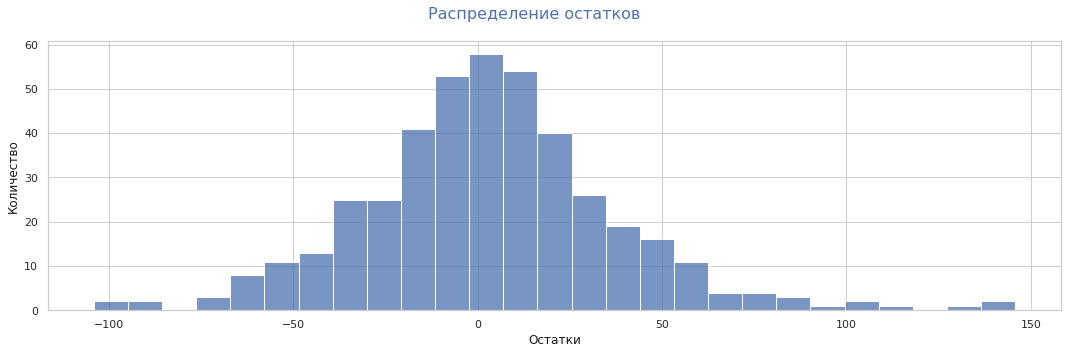

In [61]:
plt.figure(figsize=(15, 5))
sns.histplot(data=test["num_orders"] - predict_result)
add_plot_titles(suptitle="Распределение остатков", show=True,
               xlabel="Остатки", ylabel="Количество")

Распределение остатков бимодальное, больше значений вблизи нулевого значения. Превышение предсказаний над фактическими данными не более 100 заказов, однако размах заниженных предсказаний приближается к 150 заказам. Оценим дисперсию остатков.

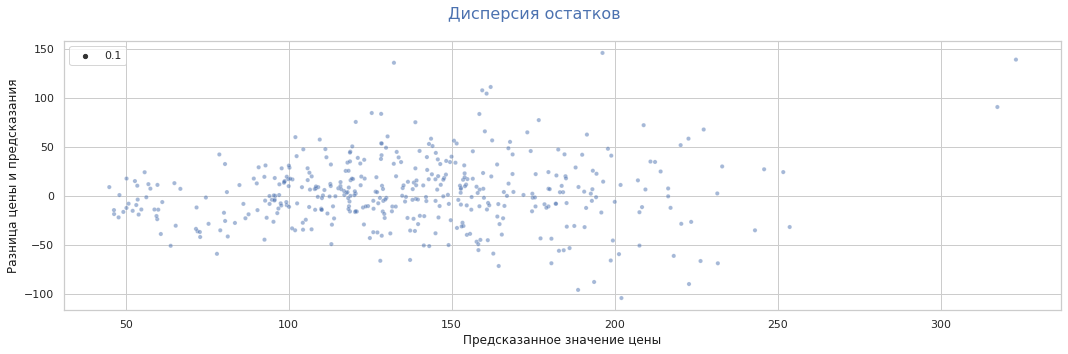

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Предсказание,425.0,136.96208,44.724865,44.976361,48.377359,59.501655,107.989161,134.970001,162.756347,212.082467,245.147974,323.055876


In [62]:
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x=predict_result, y=test["num_orders"] - predict_result,
    size=.1, alpha=0.5
)
add_plot_titles(suptitle="Дисперсия остатков", show=True,
               xlabel="Предсказанное значение цены", ylabel="Разница цены и предсказания")
predict_result.rename("Предсказание").describe(
    percentiles=[0.01, 0.05, .25, .5, .75, .95, .99]
).to_frame().T

По дисперсии остатков можно отметить, что для более высоких предсказаний заметен больший разброс, при этом предсказания выше 200 имеют тенденцию к завышению, а самые высокие предсказания сильно занижены. Вероятно это вызвано повышением дисперсии и сильными выбросами по количеству заказов в августе.

Оценим значимость признаков для модели.

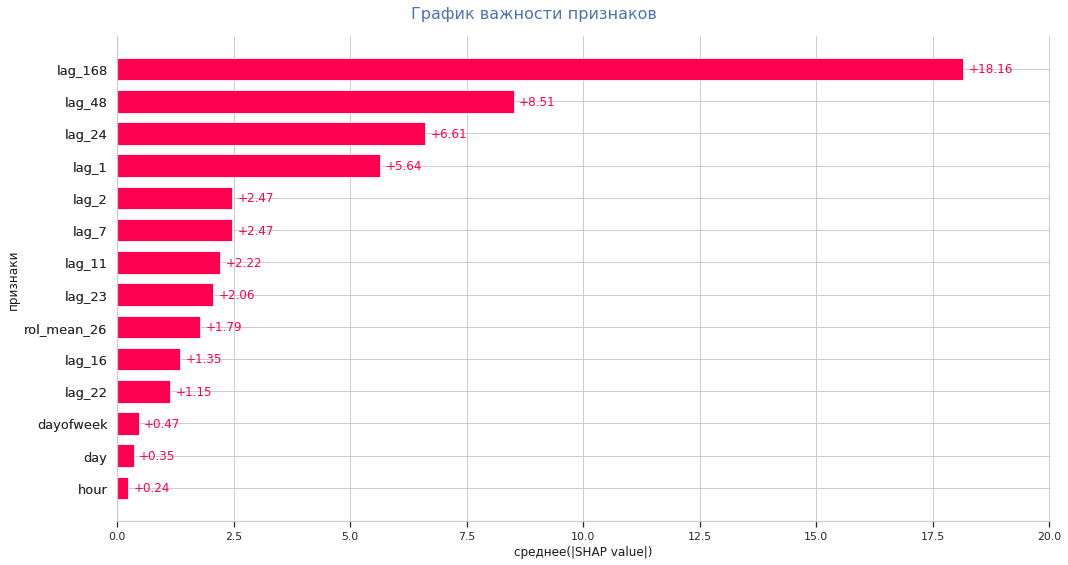

In [63]:
shap_explainer = shap.LinearExplainer(model, test.drop(columns=["num_orders"]))
shap_values = shap_explainer(test.drop(columns=["num_orders"]))
plt.figure(figsize=(15, 8))
shap.plots.bar(shap_values, max_display=14, show=False, ax=plt.gca())
add_plot_titles(suptitle="График важности признаков", show=True,
               xlabel="среднее(|SHAP value|)", ylabel="признаки")

Наиболее влиятельными являются признаки лага, особенно недельный лаг. С большим отставанием от недельного по мере снижения важности идут лаги на 48, 24 и 1 час. Далее важность признаков снижается более чем в 2 раза для лагов в 7, 2, 11 и 23 часа. После них идет скользящая средняя с оконом 26 и остальные признаки.

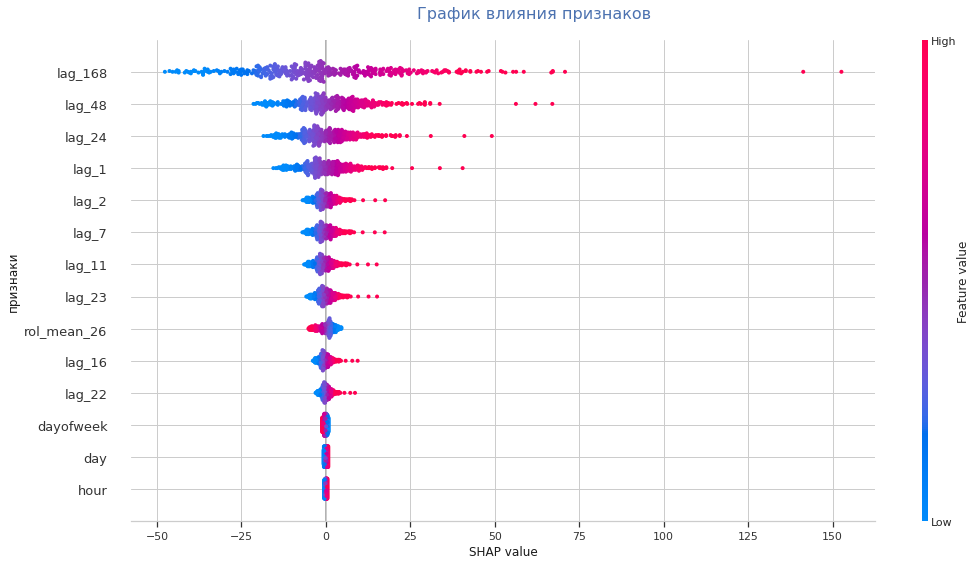

In [64]:
shap.plots.beeswarm(shap_values, max_display=14, show=False, plot_size=(15, 8))
add_plot_titles(suptitle="График влияния признаков", show=True,
               xlabel="SHAP value", ylabel="признаки")

Все признаки, кроме скользящего среднего, а также дня недели имеют прямое влияние на предсказание. 

Так как наиболее влиятельным признаком является недельный лаг, оценим также метрику для него чтобы лучше оценить адекватность модели.

In [65]:
# Предсказание на основе предыдущего значения
prev_vals = test["num_orders"].shift(168)
prev_vals[0:168] = train["num_orders"][-168:]
test_metrics.loc["Prevous_week", "metric"] = root_mean_squared_error(
    test["num_orders"], prev_vals
)
test_metrics.sort_values("metric").style.background_gradient(
    cmap=sns.diverging_palette(250, 20, as_cmap=True), 
).format("{:.4f}")

,metric
Ridge,34.5429
Prevous_week,39.2869
Prevous_hour,58.8197
Constant,87.0392


Значение недельного лага является достаточно близким по метрике RMSE и даже входит в ограничение задания - не более 48. Линейная регрессия улучшает метрику по сравнению со значениями предыдущей недели на 5, что считаю довольно хорошим результатом.

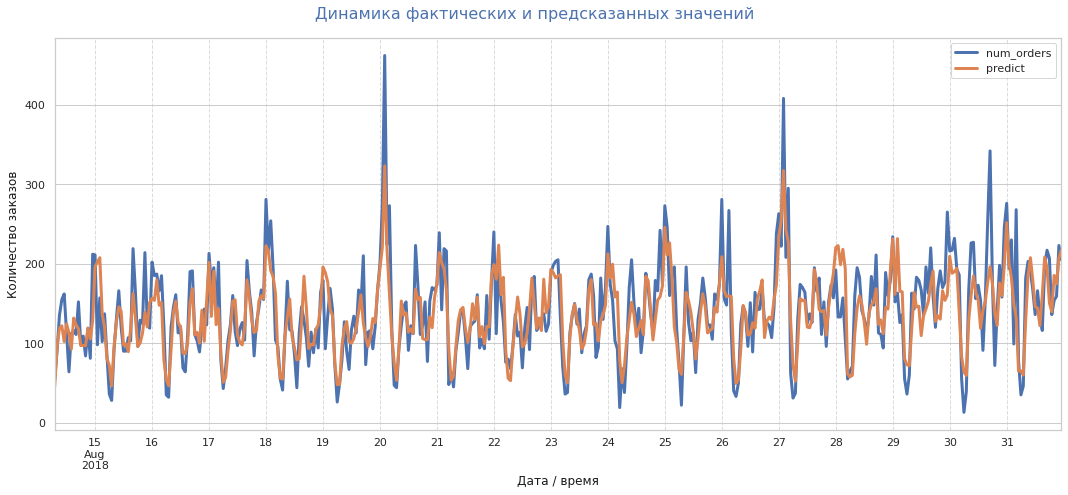

In [66]:
sns.set_context("notebook", rc={"lines.linewidth": 3})
plt.figure(figsize=(15,7))
pd.concat(
    [test["num_orders"], predict_result], axis=1
).plot(ax=plt.gca())
add_plot_titles(
    suptitle="Динамика фактических и предсказанных значений", xlabel="Дата / время", 
    ylabel="Количество заказов", show=True)

Модель достаточно хорошо предсказыает общую тенденцию - движение фактических и предсказанных значений совпадают, однако в большинстве случаев предсказанные значения не доходят до самых крайних отклонений, особенно имеющих большую амплитуду колебаний значения целевого признака. Для более низких фактических значений модель дает более высокие предсказания, а самые высокие в основном занижает, хотя иногда встречаются и завышенные предсказания, когда колебания фактических значений вверх небольшие. Наиболее ярко это заметно в ночь на 28-е и 29-е августа, а также с 18-го на 19-е число.

### Промежуточные выводы

По результатам предсказания лучшей модели Ridge на тестовых данных значение метрики RMSE составило **34.5429** что подходит под ограничения задания. 

Предсказания высокого количества заказов имеет больший разброс от реального количества заказов но в основном данный прогноз является более близким к реальным или завышенным, однако в виду больших выбросов по количеству заказов в августе наиболее высокие значения предсказаний оказались заниженными.

Самым важным признаком является количество заказов в этот же час на неделю раньше, причем значение RMSE для такого лага входит в ограничение задания и составляет **39.2869**. Также наиболее важными признаками являются количество заказов 48 часов и 24 часа до прогнозируемого, а также за 1 час до прогноза.

## Итоговые выводы

Произведена выгрузка данных, представленный датасет содержит временной ряд, состоящий из отрезков по 10 минут и содержит 26'496 записей. Данные отсортированы по возрастанию данных и проведена оценка хронологической последовательности (монотонности) данных - данные монотонны, разрывы отсутствуют.

В соответствии с задачей произведено ресемплирование данных по одному часу. В результате ресемплинга датафрейм сократился до 4416 записей.

Произведен анализ временного ряда и проведена инженерия признаков, в результате которой добавлены новые признаки:
1. Признаки даты и времени - день, день недели, час;
2. Лаговые признаки - предыдущие значения количества заказов за 1, 2, 7, 11, 16, 22-24, а также 48 и 168 часов до текущего;
3. Скользящая средняя с оконом в 26 часов.
После инженерии размер датасета увеличился на 15 признаков, при этом количество строк сократилось на 168 (первая неделя).

Произведено разделение датасета на тренировочную и тестовую выборки в соотношении 9:1. Проведен подбор гиперпараметров и обучение следующих моделей. 
- Линейная модель Ridge;
- Модель SVM;
- Модель kNN;
- Модель Decision Tree;
- Модель Random Forest;
- Модель XGBoost;
- Модель LightGBM;
- Модель CatBoost.

Наилучшей моделью по метрике RMSE является линейная регрессия **Ridge** со значением 22.495, скорость обучения и предсказания очень высокая. С минимальным отставанием по значению метрики идет модель градиентного бустинга **CatBoost** со значением 22.4986, однако скорость обучения самая низкая, хотя предсказание производит достаточно быстро. Немного уступает предыдущим моделям ансамблевая модель **Random Forest**, RMSE которой 22.5925, скорость обучения значительно лучше, чем CatBoost, однако проигрывает ей по скорости предсказания. Результат других моделей превышает значение 23, однако все модели по результам кросс-валидации проходят порог по значению метрики - не больше 48.

По результатам предсказания лучшей модели Ridge на тестовых данных значение метрики RMSE составило **34.5429** что подходит под ограничения задания. Метрика модели на тестовых данных значительно превосходит медианные и предыдущие значения. Проведен анализ отклонений и важности признаков.

Отклонения предсказаний более высокого количества заказов имеет больший разброс от реального количества, при этом более высокие значения прогноза немного смещаются к завышенным, однако в виду больших выбросов по количеству заказов в августе наиболее высокие значения предсказаний оказались заниженными.

Самым важным признаком является количество заказов в этот же час на неделю раньше. Стоит отметить, что значение метрики для недельного лага не превышает порог по заданию - **39.2869**. Другими наиболее важными признаками являются количество заказов за 48 часов и 24 часа до прогнозируемого, а также за 1 час до прогноза.

Все модели после обучения на тренировочных данных сохранены в папке /models.